In [1]:
import json
import re
from datetime import datetime

class CitationLogger:
    def __init__(self, author, title, repo_url, year=None):
        self.author = author
        self.title = title
        self.repo_url = repo_url
        self.year = year or datetime.now().year
        self.bib_key = self._generate_bib_key()

    def _generate_bib_key(self):
        first = re.sub(r'[^a-zA-Z]', '', self.author.split()[0].lower())
        title_token = re.sub(r'[^a-zA-Z]', '', self.title.split()[0].lower())
        return f"{first}{self.year}{title_token}"

    def markdown(self):
        return f"""### Citation  
{self.author} ({self.year}). *{self.title}*. GitHub Repository: [{self.repo_url.split('/')[-1]}]({self.repo_url})
"""

    def bibtex(self):
        return f"""@misc{{{self.bib_key},
  author       = {{{self.author}}},
  title        = {{{self.title}}},
  year         = {{{self.year}}},
  howpublished = {{\\url{{{self.repo_url}}}}},
  note         = {{GitHub Repository}}
}}"""

    def json(self):
        return {
            "author": self.author,
            "year": self.year,
            "title": self.title,
            "repository": "GitHub",
            "url": self.repo_url
        }

    def display(self):
        print(" Markdown Citation:\n")
        print(self.markdown())
        print("\n BibTeX Citation:\n")
        print(self.bibtex())
        print("\n JSON Citation:\n")
        print(json.dumps(self.json(), indent=4))


citation = CitationLogger(
    author="Nouri Baher",
    title="Hybrid Oversampling for Intrusion Detection: SMOTE + KGSMOTE",
    repo_url="https://github.com/Nouribaher/ids-hybrid-oversampling-smote-kgsmote",
    year=2025
)

citation.display()

 Markdown Citation:

### Citation  
Nouri Baher (2025). *Hybrid Oversampling for Intrusion Detection: SMOTE + KGSMOTE*. GitHub Repository: [ids-hybrid-oversampling-smote-kgsmote](https://github.com/Nouribaher/ids-hybrid-oversampling-smote-kgsmote)


 BibTeX Citation:

@misc{nouri2025hybrid,
  author       = {Nouri Baher},
  title        = {Hybrid Oversampling for Intrusion Detection: SMOTE + KGSMOTE},
  year         = {2025},
  howpublished = {\url{https://github.com/Nouribaher/ids-hybrid-oversampling-smote-kgsmote}},
  note         = {GitHub Repository}
}

 JSON Citation:

{
    "author": "Nouri Baher",
    "year": 2025,
    "title": "Hybrid Oversampling for Intrusion Detection: SMOTE + KGSMOTE",
    "repository": "GitHub",
    "url": "https://github.com/Nouribaher/ids-hybrid-oversampling-smote-kgsmote"
}


# Feature Autoencoder
- Noise factor : None - Because all data clean.
- Architecture : Encoder (ReLU) → Decoder (Sigmoid)
- Loss         : Mean Squared Error (MSE)
- Optimizer    : Adam (LR=0.001)
# First :  compressing an input into a reduced-dimensional representation called the latent space (the encoder).
# Second:  Reconstructing the original input from this compressed version (the decoder).
# Third :  As a deep neural network (DNN) , it consists of layers of artificial neurons,
           with "deep" referring to the multiple layers involved in both the encoding and decoding processes. 


In [2]:
import pandas as pd
import numpy as np
import json
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

#  Load the balanced dataset
df = pd.read_excel("results-Hybrid_Balanced.xlsx", engine="openpyxl")
X_balanced = df.values  # Assumes all columns are features

#  Build Autoencoder
def build_autoencoder(input_dim, encoding_dim=32):
    input_layer = Input(shape=(input_dim,))   # Rectified Linear Unit (ReLU)is defined by the formula f(x)= max (0,x) and introduces non-linearity
    encoded = Dense(encoding_dim, activation='relu')(input_layer) # compresses input features into a lower-dimensional representation.
    decoded = Dense(input_dim, activation='sigmoid')(encoded)     # reconstructs the original input from the compressed representation.
                                              # σ(x) = 1/(1+exp(-x))  the output is always between 0 and 1
 
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    encoder = Model(inputs=input_layer, outputs=encoded)

    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse') # Mean Squared Error (MSE) between original and reconstructed input
    return autoencoder, encoder

    # This setup helps the model learn to reconstruct clean feature vectors from corrupted ones—useful for anomaly detection.
   
# Train Autoencoder
input_dim = X_balanced.shape[1]
autoencoder, encoder = build_autoencoder(input_dim, encoding_dim=32)

autoencoder.fit(X_balanced, X_balanced,
                epochs=50, # It gives the model enough time to converge on clean reconstruction.
                           # Recommendation: Use epochs=100 + EarlyStopping rather than lowering to 50. 
                           # That gives flexibility and ensures you get the best model without manual tuning or overtraining.
                
                batch_size=128, # number of samples the model processes before updating its weights.
                                # If you have 10,000 samples then 1 epoch = about 78 updates (10,000 / 128 ≈ 78 batches).
                
                shuffle=True,    # Randomly shuffle training data before each epoch to reduce overfitting and improve generalization
                
                validation_split=0.1, # Reserves 10% of the training data for validation. Helps monitor performance on unseen data during training.
                
                verbose=1)      # Controls output during training: 0 = silent, 1 = progress bar, 2 = one line per epoch.

#  Compress Features
X_compressed = encoder.predict(X_balanced)
compressed_df = pd.DataFrame(X_compressed, columns=[f"latent_{i+1}" for i in range(X_compressed.shape[1])])

# Compression Metadata
metadata = pd.DataFrame({
    "original_dim": [input_dim],
    "compressed_dim": [X_compressed.shape[1]],
    "samples": [X_balanced.shape[0]],
    "source": ["results-Hybrid_Balanced.xlsx"],
    "method": ["Autoencoder (SMOTE + KGSMOTE balanced)"]
})


# Save to Excel with two sheets
with pd.ExcelWriter("compressed-Hybrid_Balanced.xlsx", engine="openpyxl") as writer:
    compressed_df.to_excel(writer, sheet_name="Compressed_Features", index=False)
    metadata.to_excel(writer, sheet_name="Compression_Metadata", index=False)

print("All-in-one compression complete. Saved to 'compressed-Hybrid_Balanced.xlsx'")

Epoch 1/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.4799 - val_loss: 25.8924
Epoch 2/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.3976 - val_loss: 25.8801
Epoch 3/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.3906 - val_loss: 25.8756
Epoch 4/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.3885 - val_loss: 25.8738
Epoch 5/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.3872 - val_loss: 25.8730
Epoch 6/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.3858 - val_loss: 25.8725
Epoch 7/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.3853 - val_loss: 25.8719
Epoch 8/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.3850 - val_loss: 25.8719
Epoch 9/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.3848 - val_loss: 25.8716
Epoch 10/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.3847 - val_loss: 25.8714
Epoch 11/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.3845 - val_loss: 25.8711
Epoch 12/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.3839 - val_loss: 25.8693
Epoch 2/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.3839 - val_loss: 25.8692
Epoch 3/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.3839 - val_loss: 25.8691
Epoch 4/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.3839 - val_loss: 25.8692
Epoch 5/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.3839 - val_loss: 25.8693
Epoch 6/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.3839 - val_loss: 25.8693
Epoch 7/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.3839 - val_loss: 25.8692
Epoch 8/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.3839 - val_loss: 25.8694
Epoch 9/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.3839 - val_loss: 25.8693
Epoch 10/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.3839 - val_loss: 25.8693
Epoch 11/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.3839 - val_loss: 25.8693
Epoch 12/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 

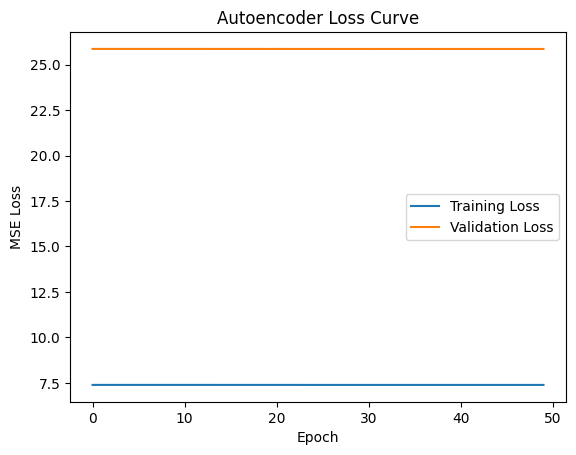

In [3]:
import matplotlib.pyplot as plt

history = autoencoder.fit(X_balanced, X_balanced,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_split=0.1,
                verbose=1)  # your training call

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Autoencoder Loss Curve')
plt.show()

# A Denoising Autoencoder is trained to reconstruct clean data from noisy input. That means, during training,
# we deliberately add random noise to the input but still use the original (clean) data as the target output.

In [4]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


# Load the dataset
file_path = "results-Hybrid_Balanced.xlsx"  # Your attached file
df = pd.read_excel(file_path, engine="openpyxl")

# Ensure all features are numeric
X = df.select_dtypes(include=[np.number]).values

# Optional normalization (recommended for autoencoders)
X = (X - X.min()) / (X.max() - X.min())

# ..........................................................................................
# Add Noise (for Denoising Autoencoder)
noise_factor = 0.1
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)
X_noisy = np.clip(X_noisy, 0., 1.)  # Keep in range [0,1]
# ..........................................................................................

#  Build Denoising Autoencoder
def build_denoising_autoencoder(input_dim, encoding_dim=32):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
 
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    encoder = Model(inputs=input_layer, outputs=encoded)

    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return autoencoder, encoder

input_dim = X.shape[1]
autoencoder, encoder = build_denoising_autoencoder(input_dim, encoding_dim=32)


# Train Denoising Autoencoder
autoencoder.fit(X_noisy, X,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_split=0.1,
                verbose=1)

# Compress Features (encoded latent space)
X_compressed = encoder.predict(X)
compressed_df = pd.DataFrame(X_compressed, columns=[f"latent_{i+1}" for i in range(X_compressed.shape[1])])

# Save compressed features and metadata
metadata = pd.DataFrame({
    "original_dim": [input_dim],
    "compressed_dim": [X_compressed.shape[1]],
    "samples": [X.shape[0]],
    "source": [file_path],
    "method": ["Denoising Autoencoder (noise_factor=0.1)"]
})

with pd.ExcelWriter("compressed-Hybrid_Balanced_DAE.xlsx", engine="openpyxl") as writer:
    compressed_df.to_excel(writer, sheet_name="Compressed_Features", index=False)
    metadata.to_excel(writer, sheet_name="Compression_Metadata", index=False)

print("Denoising Autoencoder completed! Results saved to 'compressed-Hybrid_Balanced_DAE.xlsx'")


Epoch 1/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0304 - val_loss: 0.0031
Epoch 2/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.3330e-04 - val_loss: 0.0011
Epoch 3/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.3331e-04 - val_loss: 6.5067e-04
Epoch 4/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.8018e-04 - val_loss: 5.3140e-04
Epoch 5/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.6284e-04 - val_loss: 4.7956e-04
Epoch 6/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.5172e-04 - val_loss: 4.5201e-04
Epoch 7/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.4202e-04 - val_loss: 4.6030e-04
Epoch 8/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.3298e-04 - val_loss: 4.3346e-04
Epoch 9/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.2364e-04 - val_loss: 4.2085e-04
Epoch 10/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.1289e-04 - val_loss: 4.1958e-04
Epoch 11/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.0088e-04

Epoch 1/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2389e-04 - val_loss: 4.5656e-04
Epoch 2/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2413e-04 - val_loss: 4.5931e-04
Epoch 3/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2369e-04 - val_loss: 4.3424e-04
Epoch 4/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2376e-04 - val_loss: 4.3005e-04
Epoch 5/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2377e-04 - val_loss: 4.4664e-04
Epoch 6/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2356e-04 - val_loss: 4.4399e-04
Epoch 7/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2361e-04 - val_loss: 4.2929e-04
Epoch 8/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2394e-04 - val_loss: 4.4268e-04
Epoch 9/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2377e-04 - val_loss: 4.2381e-04
Epoch 10/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2362e-04 - val_loss: 4.1174e-04
Epoch 11/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss

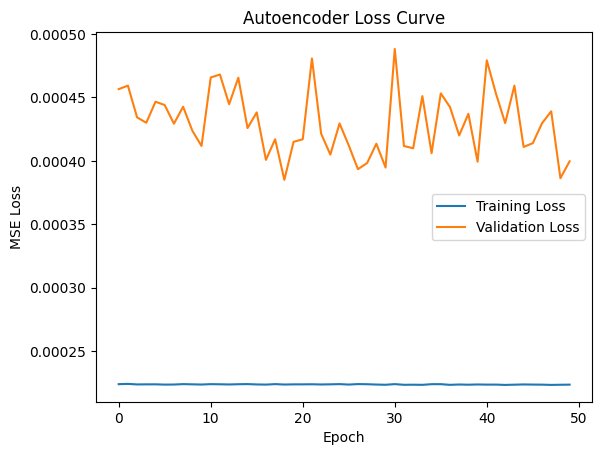

In [5]:
import matplotlib.pyplot as plt

history = autoencoder.fit(X_noisy, X,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_split=0.1,
                verbose=1)  # your training call

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Autoencoder Loss Curve')
plt.show()

In [6]:
import pandas as pd
import numpy as np
import json
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load the balanced dataset
df = pd.read_excel("results-Hybrid_Balanced.xlsx", engine="openpyxl")
X_balanced = df.values  # Assumes all columns are features

#  Inject Gaussian Noise for Denoising Autoencoder
noise_factor = 0.1
X_noisy = X_balanced + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_balanced.shape)
X_noisy = np.clip(X_noisy, 0., 1.)  # Keep values in [0, 1]

#  Build Deeper Autoencoder with Dropout
def build_autoencoder(input_dim, encoding_dim=32):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dropout(0.2)(encoded)
    bottleneck = Dense(encoding_dim, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='sigmoid')(bottleneck)

    autoencoder = Model(inputs=input_layer, outputs=decoded)
    encoder = Model(inputs=input_layer, outputs=bottleneck)

    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return autoencoder, encoder

# Train Autoencoder with EarlyStopping
input_dim = X_balanced.shape[1]
autoencoder, encoder = build_autoencoder(input_dim, encoding_dim=32)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = autoencoder.fit(X_noisy, X_balanced,
                          epochs=100,
                          batch_size=128,
                          shuffle=True,
                          validation_split=0.1,
                          verbose=1,
                          callbacks=[early_stop])

#  Compress Features
X_compressed = encoder.predict(X_balanced)
compressed_df = pd.DataFrame(X_compressed, columns=[f"latent_{i+1}" for i in range(X_compressed.shape[1])])

#  Log Reconstruction Error
X_reconstructed = autoencoder.predict(X_balanced)
recon_error = np.mean(np.square(X_balanced - X_reconstructed), axis=1)
error_df = pd.DataFrame({"reconstruction_error": recon_error})

# Compression Metadata
metadata = pd.DataFrame({
    "original_dim": [input_dim],
    "compressed_dim": [X_compressed.shape[1]],
    "samples": [X_balanced.shape[0]],
    "source": ["results-Hybrid_Balanced.xlsx"],
    "method": ["Denoising Autoencoder (SMOTE + KGSMOTE balanced)"]
})

#  Save to Excel with three sheets
with pd.ExcelWriter("compressed-Hybrid_Balanced-Denoising.xlsx", engine="openpyxl") as writer:
    compressed_df.to_excel(writer, sheet_name="Compressed_Features", index=False)
    error_df.to_excel(writer, sheet_name="Reconstruction_Error", index=False)
    metadata.to_excel(writer, sheet_name="Compression_Metadata", index=False)

print(" Denoising autoencoder complete. Saved to 'compressed-Hybrid_Balanced.xlsx'")

Epoch 1/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.4641 - val_loss: 25.8930
Epoch 2/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.3984 - val_loss: 25.8813
Epoch 3/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.3927 - val_loss: 25.8778
Epoch 4/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.3904 - val_loss: 25.8758
Epoch 5/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.3892 - val_loss: 25.8745
Epoch 6/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.3885 - val_loss: 25.8740
Epoch 7/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.3880 - val_loss: 25.8734
Epoch 8/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.3877 - val_loss: 25.8728
Epoch 9/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.3874 - val_loss: 25.8723
Epoch 10/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.3872 - val_loss: 25.8723
Epoch 11/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.3870 - val_loss: 25.8723
Epoch 12/100
473/473 ━━━━━━━━━

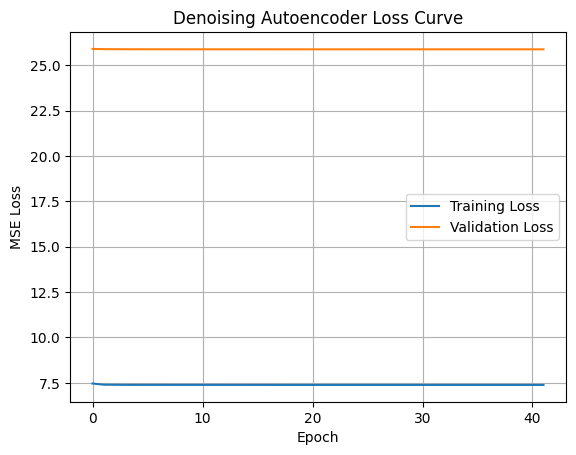

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Denoising Autoencoder Loss Curve')
plt.legend()
plt.grid(True)
plt.show()